In [ ]:
!unzip '/content/bees and ants.zip' -d '/content/bees and ants'

Archive:  /content/bees and ants.zip
  inflating: /content/bees and ants/README.md  
  inflating: /content/bees and ants/cover.jpg  
  inflating: /content/bees and ants/hymenoptera/train/ants/0013035.jpg  
  inflating: /content/bees and ants/hymenoptera/train/ants/1030023514_aad5c608f9.jpg  
  inflating: /content/bees and ants/hymenoptera/train/ants/1095476100_3906d8afde.jpg  
  inflating: /content/bees and ants/hymenoptera/train/ants/1099452230_d1949d3250.jpg  
  inflating: /content/bees and ants/hymenoptera/train/ants/116570827_e9c126745d.jpg  
  inflating: /content/bees and ants/hymenoptera/train/ants/1225872729_6f0856588f.jpg  
  inflating: /content/bees and ants/hymenoptera/train/ants/1262877379_64fcada201.jpg  
  inflating: /content/bees and ants/hymenoptera/train/ants/1269756697_0bce92cdab.jpg  
  inflating: /content/bees and ants/hymenoptera/train/ants/1286984635_5119e80de1.jpg  
  inflating: /content/bees and ants/hymenoptera/train/ants/132478121_2a430adea2.jpg  
  inflating: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/bees and ants/hymenoptera'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


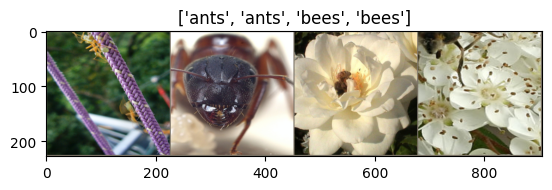

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
pip install matplotlib

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 71.3MB/s]


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=10)

Epoch 0/9
----------
train Loss: 0.6352 Acc: 0.6803
val Loss: 0.3155 Acc: 0.8758

Epoch 1/9
----------
train Loss: 0.5226 Acc: 0.7828
val Loss: 0.3568 Acc: 0.8758

Epoch 2/9
----------
train Loss: 0.5414 Acc: 0.7869
val Loss: 0.2112 Acc: 0.9216

Epoch 3/9
----------
train Loss: 0.4350 Acc: 0.8156
val Loss: 0.1474 Acc: 0.9412

Epoch 4/9
----------
train Loss: 0.3683 Acc: 0.8443
val Loss: 0.3360 Acc: 0.8693

Epoch 5/9
----------
train Loss: 0.4624 Acc: 0.7828
val Loss: 0.2525 Acc: 0.9150

Epoch 6/9
----------
train Loss: 0.5614 Acc: 0.7787
val Loss: 0.2723 Acc: 0.8954

Epoch 7/9
----------
train Loss: 0.4024 Acc: 0.8115
val Loss: 0.2759 Acc: 0.8758

Epoch 8/9
----------
train Loss: 0.3871 Acc: 0.8279
val Loss: 0.2321 Acc: 0.9020

Epoch 9/9
----------
train Loss: 0.3204 Acc: 0.8689
val Loss: 0.2282 Acc: 0.8889

Training complete in 0m 34s
Best val Acc: 0.941176


<ipython-input-8-5dea89373802>:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

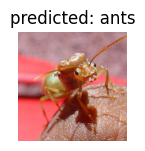

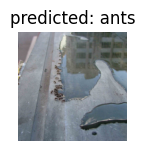

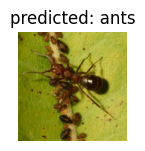

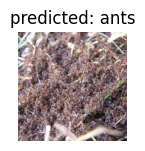

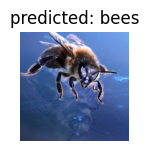

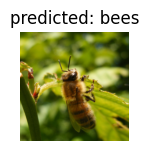

In [ ]:
visualize_model(model_ft)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.6568 Acc: 0.6639
val Loss: 0.4907 Acc: 0.7647

Epoch 1/9
----------
train Loss: 0.3643 Acc: 0.8484
val Loss: 0.1964 Acc: 0.9346

Epoch 2/9
----------
train Loss: 0.4318 Acc: 0.8033
val Loss: 0.1865 Acc: 0.9477

Epoch 3/9
----------
train Loss: 0.5328 Acc: 0.7623
val Loss: 0.2574 Acc: 0.9150

Epoch 4/9
----------
train Loss: 0.5242 Acc: 0.8156
val Loss: 0.1859 Acc: 0.9412

Epoch 5/9
----------
train Loss: 0.4424 Acc: 0.8033
val Loss: 0.1939 Acc: 0.9412

Epoch 6/9
----------
train Loss: 0.4792 Acc: 0.8156
val Loss: 0.1882 Acc: 0.9542

Epoch 7/9
----------
train Loss: 0.3276 Acc: 0.8730
val Loss: 0.2067 Acc: 0.9477

Epoch 8/9
----------
train Loss: 0.3464 Acc: 0.8607
val Loss: 0.1888 Acc: 0.9477

Epoch 9/9
----------
train Loss: 0.2962 Acc: 0.8770
val Loss: 0.1960 Acc: 0.9477

Training complete in 0m 31s
Best val Acc: 0.954248


<ipython-input-8-5dea89373802>:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


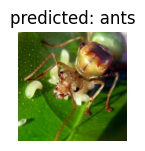

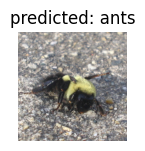

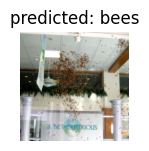

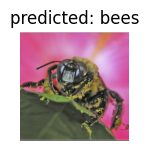

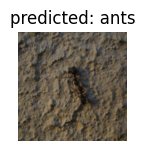

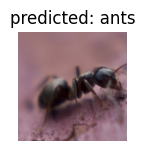

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [ ]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)


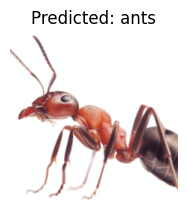

In [ ]:
visualize_model_predictions(
    model_conv,
    img_path='/content/ants.jpg'
)

plt.ioff()
plt.show()

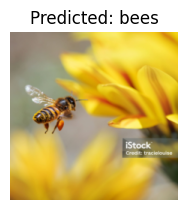

In [ ]:
visualize_model_predictions(
    model_conv,
    img_path='/content/bee1.jpg'
)

plt.ioff()
plt.show()

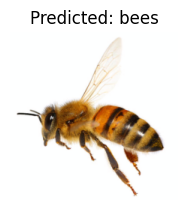

In [ ]:
visualize_model_predictions(
    model_conv,
    img_path='/content/bee2.jpg'
)

plt.ioff()
plt.show()

In [ ]:
!unzip '/content/archive.zip' -d '/content/pizzafinal'

Archive:  /content/archive.zip
  inflating: /content/pizzafinal/food101_subset.py  
  inflating: /content/pizzafinal/test/not_pizza/3104030.jpg  
  inflating: /content/pizzafinal/test/not_pizza/3108314.jpg  
  inflating: /content/pizzafinal/test/not_pizza/3108421.jpg  
  inflating: /content/pizzafinal/test/not_pizza/3123099.jpg  
  inflating: /content/pizzafinal/test/not_pizza/3125420.jpg  
  inflating: /content/pizzafinal/test/not_pizza/3130083.jpg  
  inflating: /content/pizzafinal/test/not_pizza/3131740.jpg  
  inflating: /content/pizzafinal/test/not_pizza/3139810.jpg  
  inflating: /content/pizzafinal/test/not_pizza/3140015.jpg  
  inflating: /content/pizzafinal/test/not_pizza/3140258.jpg  
  inflating: /content/pizzafinal/test/not_pizza/3141241.jpg  
  inflating: /content/pizzafinal/test/not_pizza/3146311.jpg  
  inflating: /content/pizzafinal/test/not_pizza/3148100.jpg  
  inflating: /content/pizzafinal/test/not_pizza/3148679.jpg  
  inflating: /content/pizzafinal/test/not_pizza/

In [ ]:
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/pizzafinal'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


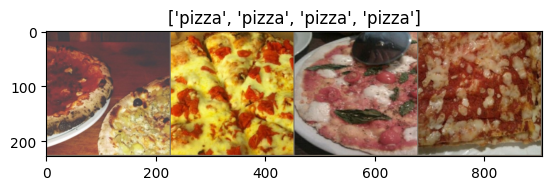

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 170MB/s]


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=10)

Epoch 0/9
----------
train Loss: 0.6754 Acc: 0.7331
val Loss: 0.2304 Acc: 0.9126

Epoch 1/9
----------
train Loss: 0.5861 Acc: 0.7719
val Loss: 0.3149 Acc: 0.8962

Epoch 2/9
----------
train Loss: 0.6031 Acc: 0.7631
val Loss: 0.3235 Acc: 0.8443

Epoch 3/9
----------
train Loss: 0.5474 Acc: 0.7775
val Loss: 0.2122 Acc: 0.9290

Epoch 4/9
----------
train Loss: 0.5144 Acc: 0.8063
val Loss: 0.2959 Acc: 0.8770

Epoch 5/9
----------
train Loss: 0.4558 Acc: 0.8181
val Loss: 0.2330 Acc: 0.9126

Epoch 6/9
----------
train Loss: 0.4835 Acc: 0.8169
val Loss: 0.2270 Acc: 0.8989

Epoch 7/9
----------
train Loss: 0.3484 Acc: 0.8475
val Loss: 0.1909 Acc: 0.9180

Epoch 8/9
----------
train Loss: 0.3351 Acc: 0.8662
val Loss: 0.1712 Acc: 0.9262

Epoch 9/9
----------
train Loss: 0.3077 Acc: 0.8694
val Loss: 0.1837 Acc: 0.9208

Training complete in 2m 12s
Best val Acc: 0.928962


<ipython-input-28-5dea89373802>:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

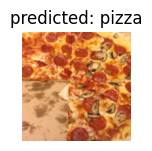

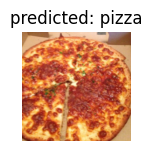

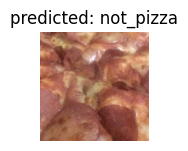

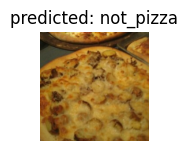

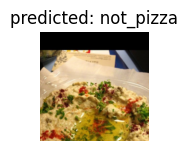

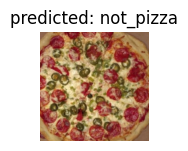

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [ ]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)


In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.5233 Acc: 0.7431
val Loss: 0.4333 Acc: 0.8361

Epoch 1/9
----------
train Loss: 0.4983 Acc: 0.7838
val Loss: 0.2001 Acc: 0.9071

Epoch 2/9
----------
train Loss: 0.5138 Acc: 0.7950
val Loss: 0.2859 Acc: 0.8962

Epoch 3/9
----------
train Loss: 0.5769 Acc: 0.7669
val Loss: 0.1792 Acc: 0.9235

Epoch 4/9
----------
train Loss: 0.5857 Acc: 0.7750
val Loss: 0.1587 Acc: 0.9372

Epoch 5/9
----------
train Loss: 0.5111 Acc: 0.7950
val Loss: 0.1801 Acc: 0.9262

Epoch 6/9
----------
train Loss: 0.5267 Acc: 0.7919
val Loss: 0.2408 Acc: 0.8907

Epoch 7/9
----------
train Loss: 0.4287 Acc: 0.8075
val Loss: 0.1962 Acc: 0.9153

Epoch 8/9
----------
train Loss: 0.3999 Acc: 0.8250
val Loss: 0.1722 Acc: 0.9208

Epoch 9/9
----------
train Loss: 0.4277 Acc: 0.8113
val Loss: 0.1779 Acc: 0.9235

Training complete in 1m 45s
Best val Acc: 0.937158


<ipython-input-7-5dea89373802>:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


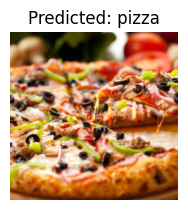

In [ ]:
visualize_model_predictions(
    model_conv,
    img_path='/content/pizza.jpg'
)

plt.ioff()
plt.show()

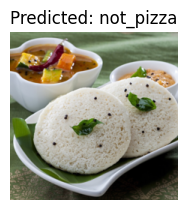

In [ ]:
visualize_model_predictions(
    model_conv,
    img_path='/content/idli.jpg'
)

plt.ioff()
plt.show()